# Stadtratswahl -- mal ganz schnell
**Aufgabe:** Innert Minuten sollen die kompletten Resultate der Stadtratswahl (80 Sitze, 511 Kandidaten) umgerechnet werden -- damit es möglichst für die gesamte Printauflage reicht. Das geht nur automatisch...

In [9]:
# Die Datei mit den Detailergebnissen wird heruntergeladen. 

!wget http://www.bern.ch/themen/stadt-recht-und-politik/abstimmungen-und-wahlen/gemeindewahlen/gemeindewahlen-2016-1/wahlresultate/stadtratswahlen-2016-resultate-und-auswertungen-ganze-stadt-bern/detailergebnisse-stadtratswahlen-2016-formblatt-5b.pdf > .log.txt
!evince /home/this/Downloads/Detailergebnisse\ Stadtratswahlen\ 2016_Formblatt_5b.pdf > .log.txt

--2016-12-01 11:02:34--  http://www.bern.ch/themen/stadt-recht-und-politik/abstimmungen-und-wahlen/gemeindewahlen/gemeindewahlen-2016-1/wahlresultate/stadtratswahlen-2016-resultate-und-auswertungen-ganze-stadt-bern/detailergebnisse-stadtratswahlen-2016-formblatt-5b.pdf
Auflösen des Hostnamens »www.bern.ch (www.bern.ch)« … 193.247.32.15
Verbindungsaufbau zu www.bern.ch (www.bern.ch)|193.247.32.15|:80 … verbunden.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 302 Moved Temporarily
Platz: http://www.bern.ch/themen/stadt-recht-und-politik/abstimmungen-und-wahlen/gemeindewahlen/gemeindewahlen-2016-1/wahlresultate/stadtratswahlen-2016-resultate-und-auswertungen-ganze-stadt-bern/detailergebnisse-stadtratswahlen-2016-formblatt-5b.pdf/download [folgend]
--2016-12-01 11:02:40--  http://www.bern.ch/themen/stadt-recht-und-politik/abstimmungen-und-wahlen/gemeindewahlen/gemeindewahlen-2016-1/wahlresultate/stadtratswahlen-2016-resultate-und-auswertungen-ganze-stadt-bern/detailergebnisse-stad

Vorarbeit: 

* Das PDF mit den Dateilergebnissen der Stadtratswahl wird mit Tabula ausgelesen. Pro Seite wird der gesamte Bereich mit den Angaben zur Partei, den Gewählten und Nichtgewählten sowie den summierten Ergebenissen markiert.

In [23]:
!rm -r /home/this/Dokumente/bz/wahl_stadtrat/resultate/*
!mkdir /home/this/Dokumente/bz/wahl_stadtrat/resultate/grafik/
!unzip /home/this/Downloads/tabula-Detailergebnisse\ Stadtratswahlen\ 2016_Formblatt_5b.zip -d /home/this/Dokumente/bz/wahl_stadtrat/resultate/ > log.txt

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import matplotlib
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['pdf.fonttype'] = 42
import folium

In [25]:
# Zuerst werden die Dateien umbenannt.

#importdateien = 'tabula-ergebnisse_sr__gesamt_wahlen_2012 (1)-'
importdateien = 'tabula-Detailergebnisse Stadtratswahlen 2016_Formblatt_5b-'

arbeitsverzeichnis = '/home/this/Dokumente/bz/wahl_stadtrat/resultate/'

for dateiname in os.listdir(arbeitsverzeichnis):
    if dateiname.endswith(".csv"):
        neuer_name = dateiname.replace(importdateien, '')
        if re.match(r'\d.csv', neuer_name):
            neuer_name = '0' + neuer_name
        alter_name = os.path.join(arbeitsverzeichnis, dateiname)
        neuer_name = os.path.join(arbeitsverzeichnis, neuer_name)
        os.rename(alter_name, neuer_name)

In [27]:
# Bei welchen Dateien handelt es sich um Fortsetzungen? 
fortsetzungen = list()

for dateiname in os.listdir(arbeitsverzeichnis):
    try:
        erste_zeile = pd.read_csv(arbeitsverzeichnis + dateiname, nrows=0)
        erste_zelle = erste_zeile.iloc[:, [0]]
        if 'Liste' in erste_zelle.columns.tolist()[0]:
            pass
        else:
            fortsetzungen.append(int(dateiname[-6:-4]))
    except:
        pass
fortsetzungen.sort()
fortsetzungen

[1, 16]

In [28]:
# Anfügen der Wahllisten, die bloss Fortsetzungen sind. 

for fortsetzung in fortsetzungen:
    if fortsetzung < 10:
        anfang = arbeitsverzeichnis + '0' + str(fortsetzung - 1) + '.csv'
        ende = arbeitsverzeichnis + '0' + str(fortsetzung) + '.csv'
    elif fortsetzung == 10:
        anfang = arbeitsverzeichnis + '0' + str(fortsetzung - 1) + '.csv'
        ende = arbeitsverzeichnis + str(fortsetzung) + '.csv'
    else:
        anfang = arbeitsverzeichnis + str(fortsetzung - 1) + '.csv'
        ende = arbeitsverzeichnis + str(fortsetzung) + '.csv'

    # Die Fortsetzungen enthalten weniger Spalten. Deshalb werden nun zwei Spalten eingefügt.
    df_fortsetzung = pd.read_csv(ende, header=None)
    df_fortsetzung['Leerspalte1'] = ''
    df_fortsetzung['Leerspalte2'] = ''
    df_fortsetzung = df_fortsetzung[[0,'Leerspalte1', 'Leerspalte2', 1]]
    df_fortsetzung.to_csv(ende, header=None, index=None)
    
    # Nun wird die Fortsetzung der ursprünglichen Datei angefügt. 
    kommando = 'cat ' + ende + ' >> ' + anfang
    os.system('%s' % (kommando))
    
    # Schliesslich wird die Fortsetzung gelöscht.
    os.remove(ende)

In [29]:
csv_listen = list()

for dateiname in os.listdir(arbeitsverzeichnis):
    if dateiname.endswith(".csv"):
        csv_listen.append(dateiname)
csv_listen.sort()

In [30]:
def lade_liste(arbeitsverzeichnis, wahlliste):
    df_liste = pd.read_csv(arbeitsverzeichnis + wahlliste)
    partei = df_liste.columns.values[1]
    df_liste['Liste'] = partei
    df_liste = df_liste.ix[1:]
    df_liste = df_liste.drop(df_liste.columns[[1, 2]], axis=1)
    df_liste.columns = [['Nameberuf', 'Stimmen', 'Liste']]
#    df_liste.dropna(inplace=True)
    return df_liste

In [31]:
# Trenne den Namen von den Berufsbezeichnungen. 
def extrahiere_name(nameberuf):
    try:
        temp_name = re.search(r'\d+. (.*?)\,', nameberuf)
        return temp_name.group(1)
    except:
        pass

def extrahiere_beruf(nameberuf):
    try:
        temp_beruf = re.search(r'\d+. (.*?)\, (.*?)\, \d+', nameberuf)
        return temp_beruf.group(2)
    except:
        pass

def extrahiere_plz(nameberuf):
    try:
        temp_plz = re.search(r'\d{4}', nameberuf)
        return temp_plz.group(0)
    except:
        pass

def extrahiere_ort(nameberuf):
    try:
        temp_ort = re.search(r'\d{4} (.*?)$', nameberuf)
        return temp_ort.group(1)
    except:
        pass

# Entferne das Tausendertrenn-Apostroph. Konvertiere zu Int.
def adieu_apostroph(stimmen):
    try:
        return int(stimmen.replace('\'', ''))
    except:
        pass

# Die Startzeilen der Rubriken "gewählt sind" und "nicht gewählt sind" werden ausgelesen.
def schnippschnapp2(df_liste):
    print(df_liste)

    return 'Fertig'

# Die Startzeilen der Rubriken "gewählt sind" und "nicht gewählt sind" werden ausgelesen.
def schnippschnapp(df_liste):
    zettelschere = list()
    zettelschere.append(1)
    zettelschere.append(list(df_liste[df_liste['Nameberuf'].str.contains('nicht gewählt sind:')].index)[0])
    zettelschere.append(list(df_liste[df_liste['Nameberuf'].str.contains('Kandidatenstimmen')].index)[0])
    return zettelschere

In [32]:
# Leere Dataframes schmieden. 
columns = ['Name', 'Liste', 'Beruf', 'PLZ', 'Ort', 'Stimmen']

df_gewählt = pd.DataFrame(columns=columns)
df_nicht_gewählt = pd.DataFrame(columns=columns)
df_statistik = pd.DataFrame(columns=columns)

# Laden, auslesen und zerlegen der Daten für jede Liste. Anhängen an die Haupt-Dataframes. 

for csv_liste in csv_listen:
    
    # Lade die Daten
    df_liste = lade_liste(arbeitsverzeichnis, csv_liste)
    
    # Extrahiere die einzelnen Datenbankfelder. 
    df_liste['Name'] = df_liste['Nameberuf'].apply(extrahiere_name)
    df_liste['Beruf'] = df_liste['Nameberuf'].apply(extrahiere_beruf)
    df_liste['PLZ'] = df_liste['Nameberuf'].apply(extrahiere_plz)
    df_liste['Ort'] = df_liste['Nameberuf'].apply(extrahiere_ort)
    
    # Entferne das Apostroph. 
    df_liste['Stimmen'] = df_liste['Stimmen'].apply(adieu_apostroph)
    
    # Trenne die Angaben zur Liste sowie die Statistik von den eigentlichen Daten.
    zettelschere = schnippschnapp(df_liste)
    df_liste_gewählt = df_liste.loc[zettelschere[0]+1:zettelschere[1]-1]
    df_liste_gewählt = df_liste_gewählt[['Name', 'Liste', 'Beruf', 'PLZ', 'Ort', 'Stimmen']]
    df_gewählt = df_gewählt.append(df_liste_gewählt)
    
    df_liste_nicht_gewählt = df_liste[zettelschere[1]:zettelschere[2]-1]
    df_liste_nicht_gewählt = df_liste_nicht_gewählt[['Name', 'Liste', 'Beruf', 'PLZ', 'Ort', 'Stimmen']]
    df_nicht_gewählt = df_nicht_gewählt.append(df_liste_nicht_gewählt)
    
    df_liste_statistik = df_liste[zettelschere[2]:][['Liste', 'Nameberuf', 'Stimmen']]
    df_liste_statistik.columns = ['Liste', 'Art der Stimmen', 'Stimmenanzahl']
    df_statistik = df_statistik.append(df_liste_statistik)

In [33]:
# Kontrolle der Daten

print('Anzahl gewählte Personen:', len(df_gewählt))

Anzahl gewählte Personen: 80


## Export

In [34]:
# Ersetzen der abenteuerlichen Listenbezeichnungen.

listen_redigiert = {'Grünes Bündnis und Gewerkschafter_innen': 'Grünes Bündnis',
                 'Grünliberale Partei glp' : 'Grünlierale Partei (GLP)',
                 'Bürgerlich Demokratische Partei der Stadt Bern (BDP Stadt Bern)': 'Bürgerlich Demokratische Partei (BDP)',
                 'Junge Alternative JA!': 'Junge Alternative (JA!)',
                 'FDP.Die Liberalen': 'FDP',
                 'SVP Schweizerische Volkspartei': 'Schweizerische Volkspartei (SVP)',
                 'jungfreisinnige stadt bern': 'Jungfreisinnige',
                 'Alternative Linke Bern (AL Bern)': 'Alternative Linke (AL)',
                 'EDU – Suchet der Stadt Bestes': 'Eidgenössisch Demokratische Union (EDU)'}

def redaktor(liste):
    try:
        return listen_redigiert[liste]
    except:
        return liste

listen_redigiert_kurz = {'Grünes Bündnis und Gewerkschafter_innen': 'GB',
                 'Grünliberale Partei glp' : 'GLP',
                 'Bürgerlich Demokratische Partei der Stadt Bern (BDP Stadt Bern)': 'BDP',
                 'Junge Alternative JA!': 'JA!',
                 'FDP.Die Liberalen': 'FDP',
                 'SVP Schweizerische Volkspartei': 'SVP',
                 'jungfreisinnige stadt bern': 'JFDP',
                 'Alternative Linke Bern (AL Bern)': 'AL',
                 'EDU – Suchet der Stadt Bestes': 'EDU',
                 'Sozialdemokratische Partei und Gewerkschaften (SP)': 'SP',
                 'Grüne Freie Liste Stadt Bern (GFL)': 'GFL',
                 'Evangelische Volkspartei (EVP)': 'EVP', 
                 'Partei der Arbeit (PdA)': 'PdA',
                 'Junge Grünliberale (jglp)': 'JGLP',
                 'GPB-DA Grüne Partei Bern - Demokratische Alternative': 'GPB-DA',
                 'Schweizer Demokraten (SD)': 'SD'}

def redaktor_kue(liste):
    try:
        return listen_redigiert_kurz[liste]
    except:
        return liste

In [35]:
def druckerpresse(df_gewählt, liste):
    # Formatieren der Ausgabe.
    export_gewählt = df_gewählt[df_gewählt['Liste'] == liste][['Name', 'Stimmen']]
    export_gewählt['Rang'] = export_gewählt['Stimmen'].rank(ascending=False)
    export_gewählt = export_gewählt[['Rang', 'Name', 'Stimmen']]
    export_gewählt = export_gewählt.values.tolist()

    export_nicht_gewählt = df_nicht_gewählt[df_nicht_gewählt['Liste'] == liste][['Name', 'Stimmen']]
    export_nicht_gewählt['Rang'] = export_nicht_gewählt['Stimmen'].rank(ascending=False)
    export_nicht_gewählt = export_nicht_gewählt[['Rang', 'Name', 'Stimmen']]
    export_nicht_gewählt = export_nicht_gewählt.values.tolist()

    sitze = len(df_gewählt[df_gewählt['Liste'] == liste])
    
    # Korrigieren der Listenbezeichnungen
    liste_korrigiert = redaktor(liste)
    
    # Ausgabe der Daten im richtigen Format.
    if sitze == 0:
        print(liste_korrigiert, '(' + str(sitze), 'Sitze)') 
    elif sitze == 1:
        print(liste_korrigiert, '(' + str(sitze), 'Sitz)')
    else:
        print(liste_korrigiert, '(' + str(sitze), 'Sitze)')

    for kandidat in export_gewählt:
        try:
            print(str(int(kandidat[0])) + '. ', kandidat[1] + ' ' + str(int(kandidat[2])))
        except:
            pass

    print('Nicht gewählt sind:')
    for kandidat in export_nicht_gewählt:
        try: 
            print(str(int(kandidat[0])) + '. ', kandidat[1] + ' ' + str(int(kandidat[2])))
        except:
            pass
    print('\n')

In [36]:
def copyquick(df_gewählt, liste):
    # Formatieren der Ausgabe.
    export_gewählt = df_gewählt[df_gewählt['Liste'] == liste][['Name', 'Stimmen']]
    export_gewählt['Rang'] = export_gewählt['Stimmen'].rank(ascending=False)
    export_gewählt = export_gewählt[['Rang', 'Name', 'Stimmen']]
    export_gewählt = export_gewählt.values.tolist()

    export_nicht_gewählt = df_nicht_gewählt[df_nicht_gewählt['Liste'] == liste][['Name', 'Stimmen']]
    export_nicht_gewählt['Rang'] = export_nicht_gewählt['Stimmen'].rank(ascending=False)
    export_nicht_gewählt = export_nicht_gewählt[['Rang', 'Name', 'Stimmen']]
    export_nicht_gewählt = export_nicht_gewählt.values.tolist()

    sitze = len(df_gewählt[df_gewählt['Liste'] == liste])
    
    # Korrigieren der Listenbezeichnungen
    liste_korrigiert = redaktor(liste)
    
    # Ausgabe der Daten im richtigen Format.
    if sitze == 0:
        print(liste_korrigiert, '(' + str(sitze), 'Sitze)') 
    elif sitze == 1:
        print(liste_korrigiert, '(' + str(sitze), 'Sitz)')
    else:
        print(liste_korrigiert, '(' + str(sitze), 'Sitze)')

    for kandidat in export_gewählt:
        try:
            print(str(int(kandidat[0])) + '. ', kandidat[1] + ' (' + str(int(kandidat[2])) + ')')
        except:
            pass

    print('Nicht gewählt sind:')
    for kandidat in export_nicht_gewählt:
        try: 
            print(str(int(kandidat[0])) + '. ', kandidat[1] + ' (' + str(int(kandidat[2])) + ')')
        except:
            pass
    print('\n')

In [37]:
listen_komplett = df_gewählt.append(df_nicht_gewählt)
listen_komplett = listen_komplett['Liste'].unique()

for liste in listen_komplett:
    
    # Für die normale Ausgabe. Die Zahlen müssen manuell mit Ctrl-B an den rechten Rand gedrängt werden. 
    druckerpresse(df_gewählt, liste)
    
    # Wenns schnell gehen muss, wird diese Option aktiviert.
    #copyquick(df_gewählt, liste)

Grüne Freie Liste Stadt Bern (GFL) (8 Sitze)
1.  Widmer Manuel C. 8834
2.  Burkard Michael 8624
3.  Wicki Janine 8611
4.  Gutzwiller Lukas 8436
5.  Wyss Patrik 8392
6.  Cesarov-Zaugg Danielle 8337
7.  Wüthrich Marcel 8051
8.  Robertini Marco 7915
Nicht gewählt sind:
1.  Hilty Haller Brigitte 7719
2.  de Sépibus Joëlle 7717
3.  Flükiger Isabelle 7677
4.  Schmassmann Anna 7626
5.  Wyss Grandjean Debora 7625
6.  Brunner Lea 7615
7.  Reusser Lis 7604
8.  Heiz Anic 7592
9.  Misicka Susan 7574
10.  Chukwunyere-Höselbarth Francesca 7550
11.  Pertinez Angela 7502
11.  Sönmez Hasim 7502
13.  Humbel Matthias 7483
14.  Roder Hans 7478
15.  Lehmann Beni 7456
16.  Bratschi Petra 7436
17.  Seiler Christoph 7383
18.  Mäder Yves 7358
19.  Seiler Radwina 7353
20.  Streit Constantin 7333
21.  Loosli Anja Christina 7314
22.  Scheidegger Christof 7310
23.  Zaugg Gosteli Therese 7265
24.  Fuhrimann Thomas 7215
25.  Hanus Veronika 7214
26.  Fankhauser Henriette 7183
27.  Hofer Daniel 7165
28.  Zaugg Alexand

In [38]:
# Fehlersuche: In welcher Datei ist der Fehler?

!grep -r "FDP" resultate/

grep: resultate/: Datei oder Verzeichnis nicht gefunden


In [39]:
len(df_gewählt)

80

## Auswertungen

In [40]:
!mkdir /home/this/Dokumente/bz/wahl_stadtrat/resultate/grafik

mkdir: das Verzeichnis »/home/this/Dokumente/bz/wahl_stadtrat/resultate/grafik“ kann nicht angelegt werden: Die Datei existiert bereits


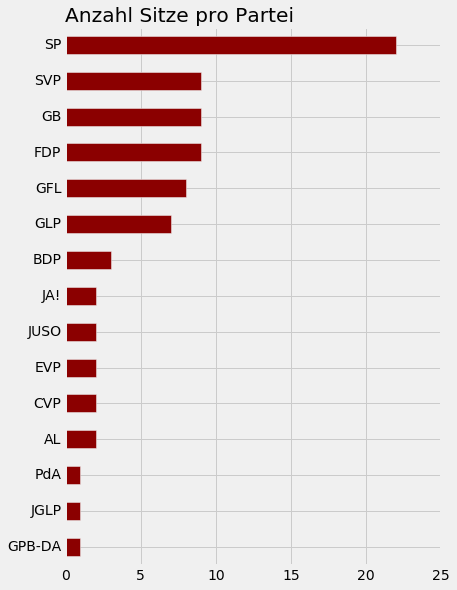

FileNotFoundError: [Errno 2] No such file or directory: 'grafik/parteienvergleich.png'

In [41]:
df_parteien = df_gewählt.groupby(by='Liste').count().sort_values(by='Stimmen', ascending=True)
df_parteien['Liste'] = df_parteien.index
df_parteien.index = df_parteien['Liste'].apply(redaktor_kue)

fig, ax = plt.subplots(figsize=(6,9))
df_parteien['Name'].plot(kind='barh', ax=ax, legend=False, color='darkred')
plt.title('Anzahl Sitze pro Partei', loc='left')
plt.xlabel('')
plt.ylabel('')
plt.show()
fig.savefig('grafik/parteienvergleich.png')
fig.savefig('grafik/parteienvergleich.svg')

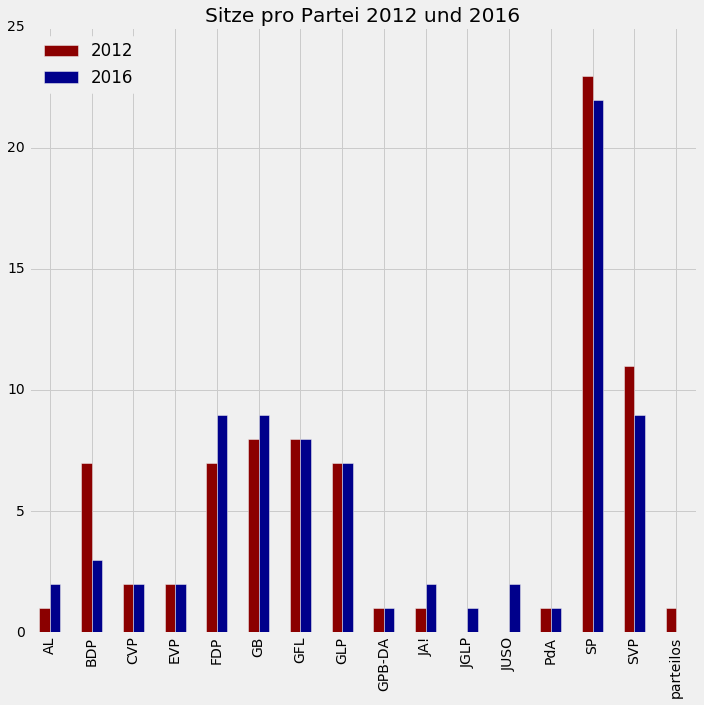

FileNotFoundError: [Errno 2] No such file or directory: 'grafik/parteienvergleich_2012_2016.png'

In [42]:
stadtrat2012 = {'SP': 23, 'SVP': 11, 'GB': 8, 'GFL': 8, 'FDP': 7, 'BDP': 7, 'GLP': 7, 
                'CVP': 2, 'EVP': 2, 'JA!': 1, 'GPB-DA': 1, 'PdA': 1, 'AL': 1, 'parteilos': 1}

df_stadtrat2012 = pd.Series(stadtrat2012, index=stadtrat2012.keys()) 
df_stadtrat2012 = pd.DataFrame(df_stadtrat2012)
df_stadtrat2012.columns = ['2012']

df_parteien_2012_2016 = df_parteien['Name']
df_parteien_2012_2016 = pd.DataFrame(df_parteien_2012_2016)
df_parteien_2012_2016.columns = ['2016']
df_parteien_2012_2016 = pd.concat([df_stadtrat2012, df_parteien_2012_2016], axis=1)

fig, ax = plt.subplots(figsize=(10,10))
df_parteien_2012_2016.plot(kind='bar', ax=ax, color=['darkred', 'darkblue'])
plt.title('Sitze pro Partei 2012 und 2016', loc='center')
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()
fig.savefig('grafik/parteienvergleich_2012_2016.png')
fig.savefig('grafik/parteienvergleich_2012_2016.svg')

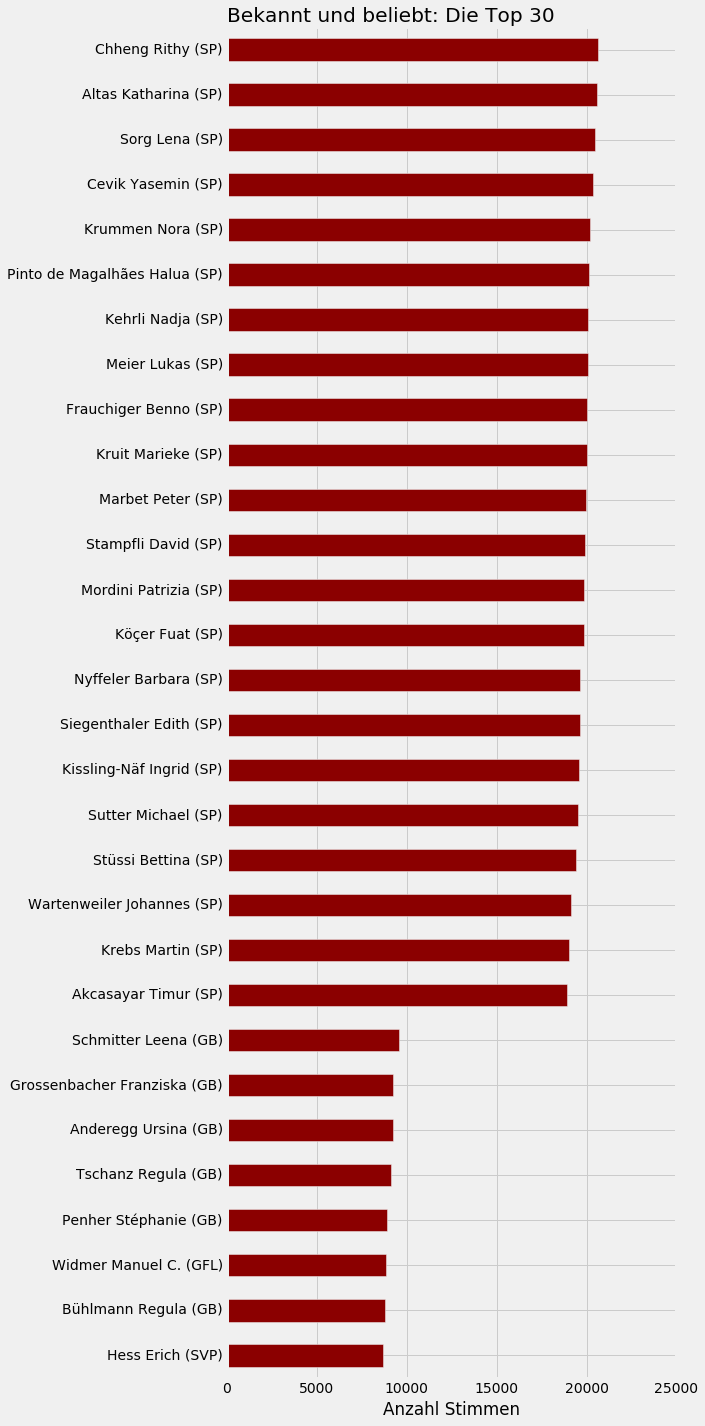

FileNotFoundError: [Errno 2] No such file or directory: 'grafik/top30.png'

In [43]:
df_top30 = df_gewählt.sort_values(by='Stimmen', ascending=False)[['Name', 'Liste', 'Stimmen']].head(30)
df_top30['Liste'] = df_top30['Liste'].apply(redaktor_kue)
df_top30.index = df_top30['Name'] + ' (' + df_top30['Liste'] + ')'

fig, ax = plt.subplots(figsize=(10,20))
df_top30[['Name', 'Stimmen']].sort_values(by='Stimmen', ascending=True).plot(kind='barh', ax=ax, legend=False, color='darkred')
plt.title('Bekannt und beliebt: Die Top 30', loc='left')
plt.xlabel('Anzahl Stimmen')
plt.ylabel('')
plt.tight_layout()
plt.show()
fig.savefig('grafik/top30.png')
fig.savefig('grafik/top30.svg')

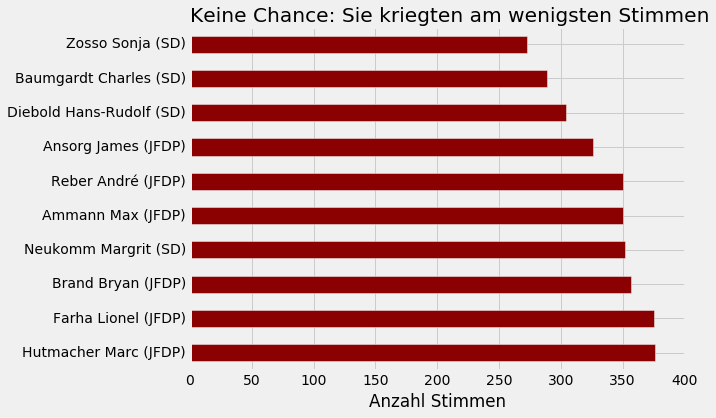

FileNotFoundError: [Errno 2] No such file or directory: 'grafik/flop10.png'

In [45]:
df_flop10 = df_nicht_gewählt.sort_values(by='Stimmen', ascending=False)[['Name', 'Liste', 'Stimmen']].dropna().tail(10)
df_flop10['Liste'] = df_flop10['Liste'].apply(redaktor_kue)
df_flop10.index = df_flop10['Name'] + ' (' + df_flop10['Liste'] + ')'

fig, ax = plt.subplots(figsize=(10,6))
df_flop10[['Name', 'Stimmen']].sort_values(by='Stimmen', ascending=False).plot(kind='barh', ax=ax, legend=False, color='darkred')
plt.title('Keine Chance: Sie kriegten am wenigsten Stimmen', loc='left')
plt.xlabel('Anzahl Stimmen')
plt.ylabel('')
plt.tight_layout()
plt.show()
fig.savefig('grafik/flop10.png')
fig.savefig('grafik/flop10.svg')

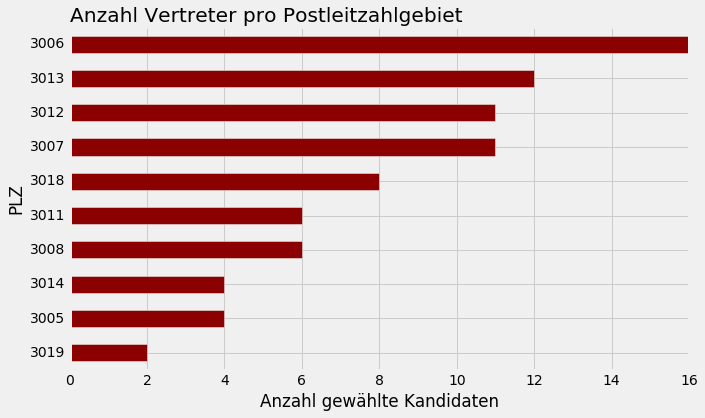

In [1605]:
# Gewählte Personen pro Postleitzahlgebiet.
fig, ax = plt.subplots(figsize=(10,6))
df_gewählt.groupby(by='PLZ')['Name'].count().sort_values(ascending=True).plot(kind='barh', color='darkred')
plt.title('Anzahl Vertreter pro Postleitzahlgebiet', loc='left')
plt.xlabel('Anzahl gewählte Kandidaten')
plt.tight_layout()
plt.show()
fig.savefig('grafik/gewählte_plz.png')
fig.savefig('grafik/gewählte_plz.svg')

In [1606]:
# Männer und Frauen.
kandidaten2016 = pd.read_csv('kandidaten2016.csv')
df_gewählt_komplett = df_gewählt.merge(kandidaten2016, left_on='Name', right_on='Name', how='inner')
df_gewählt_komplett.head()

,Name,Liste_x,Beruf_x,PLZ_x,Ort_x,Stimmen,Unnamed: 0,index,Nr.,Geburtsjahr,Geschlecht,Beruf_y,Adresse,Ort_y,Bisher,PLZ_y,Alter,Liste_y,Volle Adresse,Koordinaten
0,Widmer Manuel C.,Grüne Freie Liste Stadt Bern (GFL),Lehrer / Stadtrat / DJ,3007,Bern,8834,5,10,1112,1968,m,Lehrer/ Stadtrat/ DJ,Schwarztorstrasse 93,Bern,bisher,3007,48,GFL,"Schwarztorstrasse 93, 3007 Bern","46.9445713, 7.4262719"
1,Burkard Michael,Grüne Freie Liste Stadt Bern (GFL),Fürsprecher / Anwalt (Advokatur Burkard),3007,Bern,8624,0,0,1015,1966,m,Fürsprecher/ Anwalt (AdvokaturBurkard),Weissensteinstrasse 49B,Bern,bisher,3007,50,GFL,"Weissensteinstrasse 49B, 3007 Bern","46.9397989, 7.4260035"
2,Wicki Janine,Grüne Freie Liste Stadt Bern (GFL),"lic. iur. / Beratungsfirma ""Janine Wicki - die...",3008,Bern,8611,4,8,1091,1976,w,lic. iur./ Beratungsfirma Janine Wicki - die ...,Freiburgstrasse 69,Bern,bisher,3008,40,GFL,"Freiburgstrasse 69, 3008 Bern","46.9459839, 7.4169803"
3,Gutzwiller Lukas,Grüne Freie Liste Stadt Bern (GFL),Dr. ès. sc. / Energiewirtschafter BFE,3006,Bern,8436,2,4,1058,1966,m,Dr. ès. sc./ Energiewirtschafter BFE,Muristrasse 88,Bern,bisher,3006,50,GFL,"Muristrasse 88, 3006 Bern","46.9400267, 7.4687211"
4,Wyss Patrik,Grüne Freie Liste Stadt Bern (GFL),lic. rer. pol. / Projektleiter,3012,Bern,8392,7,14,1155,1975,m,lic. rer. pol./ Projektleiter,Bonstettenstrasse 16,Bern,bisher,3012,41,GFL,"Bonstettenstrasse 16, 3012 Bern","46.9586082, 7.4379384"


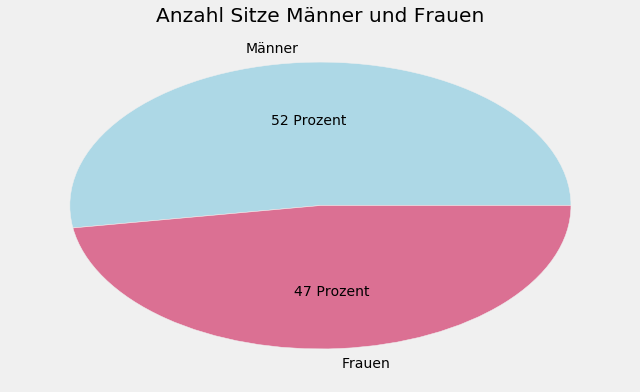

In [1607]:
fig, ax = plt.subplots(figsize=(10,6))
labels = 'Männer', 'Frauen'
colors = 'lightblue', 'palevioletred'
df_gewählt_komplett['Geschlecht'].value_counts().plot(kind='pie', labels=labels, colors=colors, autopct='%.0f' + ' Prozent', ax=ax)
plt.title('Anzahl Sitze Männer und Frauen', loc='center')
ax.set_xlabel('')
ax.set_ylabel('')
plt.show()
fig.savefig('grafik/geschlecht.png')
fig.savefig('grafik/geschlecht.svg')

In [1608]:
# Alter
df_gewählt_komplett['Alter'].describe()

count    80.000000
mean     40.862500
std      10.858985
min      20.000000
25%      33.000000
50%      39.500000
75%      48.250000
max      76.000000
Name: Alter, dtype: float64

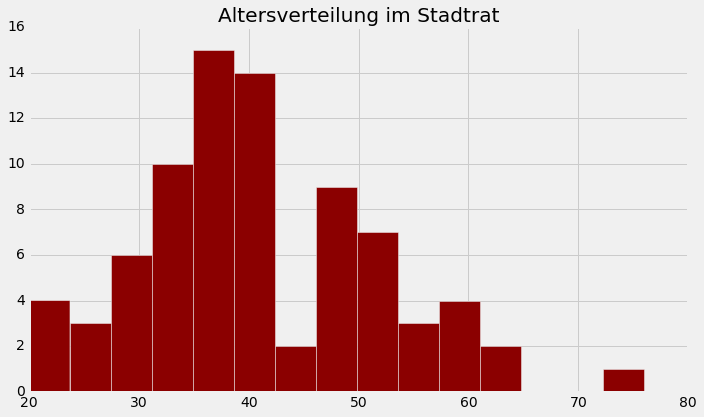

In [1609]:
fig, ax = plt.subplots(figsize=(10,6))
df_gewählt_komplett['Alter'].hist(bins=15, color='darkred', ax=ax)
ax.set_title('Altersverteilung im Stadtrat')
plt.tight_layout()
plt.show()
fig.savefig('grafik/altersverteilung.png')
fig.savefig('grafik/altersverteilung.svg')

In [1610]:
# Wo wohnen die Kandidaten (siehe interaktive Karte map_kandaten.html).
listenfarben = {'GFL' : 'green', 'SD' : 'black', 'SP' : 'green', 'CVP' : 'orange', 'JUSO' : 'green',
                 'EVP' : 'orange', 'MSB' : 'black', 'glp' : 'orange', 'SVP' : 'black', 
                 'GPB-DA' : 'red', 'GB' : 'green', 'FDP' : 'blue', 'JFDP' : 'blue', 'JA': 'green', 
                 'jglp' : 'orange', 'PdA' : 'red', 'BDP' : 'orange', 'EDU' : 'blue', 'AL' : 'red'}

map_gewählte = folium.Map(location=[46.9492,7.4428], zoom_start=13, tiles='Stamen Toner')
for kandidat in range(len(df_gewählt_komplett)):
    if df_gewählt_komplett['Koordinaten'][kandidat] == 'nan':
        print('Fehler bei:', df_gewählt_komplett['Name'][kandidat])
    elif df_gewählt_komplett['Adresse'][kandidat] == 'nan':
        print('Fehler bei:', df_gewählt_komplett['Name'][kandidat])
    elif df_gewählt_komplett['Koordinaten'][kandidat] == 'None':
        print('Fehler bei:', df_gewählt_komplett['Name'][kandidat])
    else:
        popup = " ".join([df_gewählt_komplett['Name'][kandidat], ' (' + df_gewählt_komplett['Liste_y'][kandidat] + '),', str(int(df_gewählt_komplett['Stimmen'][kandidat])) + ' Stimmen'])
        fill_color = listenfarben[df_gewählt_komplett['Liste_y'][kandidat]]
        folium.Marker([df_gewählt_komplett['Koordinaten'][kandidat]], popup=popup, icon=folium.Icon(color=fill_color),).add_to(map_gewählte)
map_gewählte.save('grafik/map_gewählte.html')
map_gewählte

Fehler bei: Schild Marianne
Fehler bei: Altas Katharina
Fehler bei: Bühlmann Regula


In [1612]:
df_gewählt_komplett = df_gewählt_komplett[['Name', 'Liste_y', 'Beruf_y', 'Adresse', 'PLZ_y', 'Ort_y', 'Alter', 'Geschlecht', 'Koordinaten', 'Stimmen']]
df_gewählt_komplett.to_excel('grafik/gewählt.xlsx')

In [1613]:
# Die Grafiken werden auf einen Memory-Stick kopiert.
!cp -r /home/this/Dokumente/bz/wahl_stadtrat/grafik/ /media/this/BREIL_PUR/stadtrat/